# Currents

This is a study of how to get a slice of current data from HYCOM.

In [1]:
import xarray as xr
import cftime
import pandas as pd
import netCDF4

For a catalog of available data see https://tds.hycom.org/thredds/catalog.html.

We pick a small slice of time, lat, lon and we drop all but the basic components of the current along the easterly (U) and Northerly (V) directions. 

Time is measured in units from a reference point. The reference point is in the metadata and we can extract it. Similarly we can check what the uhnits are. In this case we discover that the reference point is "2000-01-01 00:00:00" and the dimension contains integers that represent the number hours from that point in time. We can therefore derive an array of offsets and create a time scale using pandas as shown that return the actual date-times. 

Since the whole file is over 3 TB in size, we choose slices along each dimension to limit the actualzied size in memory. The resulting object ds does not actually contain the data but the rules by which the data need to be extracted. By typing ds, we can see what this definition contains. We can also explore each dimension individually and print min/max information as shown in the cells below.

In [2]:
# Load HYCOM dataset (example NetCDF file or URL from THREDDS)
# url = "https://tds.hycom.org/thredds/dodsC/GLBy0.08/expt_93.0/2025"
url = "https://tds.hycom.org/thredds/dodsC/GLBy0.08/expt_93.0"
# ds = xr.open_dataset(url, use_cftime=True)
# ds = xr.open_dataset(url, decode_times=False)
ds = xr.open_dataset(url, decode_times=False, decode_cf=True, ).isel(
    time=slice(-100,-1),  # Load the last 100 time steps
    lat=slice(500, 600),  # A small range of latitudes
    lon=slice(1000, 1100),  # A small range of longitudes
    drop=['tau','surf_el','water_temp','water_temp_bottom','salinity','salinity_bottom','water_u_bottom','water_v_bottom']
)
# Extract time units and reference date
units, reference_date = ds.time.attrs['units'].split('since')
reference_date = reference_date.strip()  # Remove any extra whitespace
reference_datetime = pd.to_datetime(reference_date)
print(units)
print(reference_date)

# Convert the time values to timedeltas
time_values = ds.time.values   # Assuming time values are in 'hours'
time_offsets = pd.to_timedelta(time_values, unit='h')  # Convert hours to timedelta

# Add the offsets to the reference date
actual_times = reference_datetime + time_offsets

actual_times

hours 
2000-01-01 00:00:00


DatetimeIndex(['2024-08-24 00:00:00', '2024-08-24 03:00:00',
               '2024-08-24 06:00:00', '2024-08-24 09:00:00',
               '2024-08-24 12:00:00', '2024-08-24 15:00:00',
               '2024-08-24 18:00:00', '2024-08-24 21:00:00',
               '2024-08-25 00:00:00', '2024-08-25 03:00:00',
               '2024-08-25 06:00:00', '2024-08-25 09:00:00',
               '2024-08-25 12:00:00', '2024-08-25 15:00:00',
               '2024-08-25 18:00:00', '2024-08-25 21:00:00',
               '2024-08-26 00:00:00', '2024-08-26 03:00:00',
               '2024-08-26 06:00:00', '2024-08-26 09:00:00',
               '2024-08-26 12:00:00', '2024-08-26 15:00:00',
               '2024-08-26 18:00:00', '2024-08-26 21:00:00',
               '2024-08-27 00:00:00', '2024-08-27 03:00:00',
               '2024-08-27 06:00:00', '2024-08-27 09:00:00',
               '2024-08-27 12:00:00', '2024-08-27 15:00:00',
               '2024-08-27 18:00:00', '2024-08-27 21:00:00',
               '2024-08-

In [3]:
ds

<xarray.Dataset> Size: 653MB
Dimensions:            (lat: 100, lon: 100, time: 99, depth: 40)
Coordinates:
  * lat                (lat) float64 800B -60.0 -59.96 -59.92 ... -56.08 -56.04
  * lon                (lon) float64 800B 80.0 80.08 80.16 ... 87.76 87.84 87.92
  * time               (time) float64 792B 2.16e+05 2.161e+05 ... 2.163e+05
  * depth              (depth) float64 320B 0.0 2.0 4.0 ... 3e+03 4e+03 5e+03
Data variables:
    tau                (time) float64 792B ...
    surf_el            (time, lat, lon) float32 4MB ...
    water_temp         (time, depth, lat, lon) float32 158MB ...
    water_temp_bottom  (time, lat, lon) float32 4MB ...
    salinity           (time, depth, lat, lon) float32 158MB ...
    salinity_bottom    (time, lat, lon) float32 4MB ...
    water_u            (time, depth, lat, lon) float32 158MB ...
    water_u_bottom     (time, lat, lon) float32 4MB ...
    water_v            (time, depth, lat, lon) float32 158MB ...
    water_v_bottom     (time, lat, lon) float32 4MB ...
Attributes:
    classification_level:      UNCLASSIFIED
    distribution_statement:    Approved for public release. Distribution unli...
    downgrade_date:            not applicable
    classification_authority:  not applicable
    institution:               Fleet Numerical Meteorology and Oceanography C...
    source:                    HYCOM archive file
    history:                   archv2ncdf2d
    comment:                   p-grid
    field_type:                instantaneous
    Conventions:               CF-1.6 NAVO_netcdf_v1.1

In [4]:


# Extract time units and reference date
units, reference_date = ds.time.attrs['units'].split('since')
reference_date = reference_date.strip()  # Remove any extra whitespace
reference_datetime = pd.to_datetime(reference_date)
print(units)
print(reference_date)

hours 
2000-01-01 00:00:00


In [5]:

# Add the offsets to the reference date
actual_times = reference_datetime + time_offsets

# Verify the first entry matches the calculated start time
print("First time entry:", actual_times[0])
units, reference_date = ds.time.attrs['units'].split('since')

# pd.date_range(start=reference_date, periods=ds.sizes['time'], freq='3h')
# ds['time'] = pd.date_range(start=reference_date, periods=ds.['time'][-1], freq='3h')
# ds['time'][16809]


First time entry: 2024-08-24 00:00:00


To look at samples of the coordinates we can use the coords method

In [6]:
ds.coords

Coordinates:
  * lat      (lat) float64 800B -60.0 -59.96 -59.92 ... -56.12 -56.08 -56.04
  * lon      (lon) float64 800B 80.0 80.08 80.16 80.24 ... 87.76 87.84 87.92
  * time     (time) float64 792B 2.16e+05 2.161e+05 ... 2.163e+05 2.163e+05
  * depth    (depth) float64 320B 0.0 2.0 4.0 6.0 ... 2.5e+03 3e+03 4e+03 5e+03

We can also check min/max values along each of the dimensions:

In [7]:
# Get the range of coordinates
time_range = ds["time"].min().values, ds["time"].max().values
lon_range = ds["lon"].min().values, ds["lon"].max().values
lat_range = ds["lat"].min().values, ds["lat"].max().values

print("Time range:", time_range)
print("Longitude range:", lon_range)
print("Latitude range:", lat_range)


Time range: (array(216048.), array(216342.))
Longitude range: (array(80.), array(87.92004395))
Latitude range: (array(-60.), array(-56.04000092))


... or we can print the actual values. The depths are also relevant for currents below the survace. For out purposes we choose depth = 0.
 

In [23]:
print("Time values:", ds["time"].values)
print("Longitude values:", ds["lon"].values)
print("Latitude values:", ds["lat"].values)


Time values: [216048. 216051. 216054. 216057. 216060. 216063. 216066. 216069. 216072.
 216075. 216078. 216081. 216084. 216087. 216090. 216093. 216096. 216099.
 216102. 216105. 216108. 216111. 216114. 216117. 216120. 216123. 216126.
 216129. 216132. 216135. 216138. 216141. 216144. 216147. 216150. 216153.
 216156. 216159. 216162. 216165. 216168. 216171. 216174. 216177. 216180.
 216183. 216186. 216189. 216192. 216195. 216198. 216201. 216204. 216207.
 216210. 216213. 216216. 216219. 216222. 216225. 216228. 216231. 216234.
 216237. 216240. 216243. 216246. 216249. 216252. 216255. 216258. 216261.
 216264. 216267. 216270. 216273. 216276. 216279. 216282. 216285. 216288.
 216291. 216294. 216297. 216300. 216303. 216306. 216309. 216312. 216315.
 216318. 216321. 216324. 216327. 216330. 216333. 216336. 216339. 216342.]
Longitude values: [80.         80.07995605 80.16003418 80.23999023 80.31994629 80.40002441
 80.47998047 80.56005859 80.64001465 80.7199707  80.80004883 80.88000488
 80.95996094 81.040

We can now define a furmula to compute current_magnitude that is a scalar derived from the euclidean Norm:

In [9]:

# Inspect available variables
print(ds)

# Extract U and V components
u = ds['water_u']
v = ds['water_v']

# Compute current magnitude
current_magnitude = (u**2 + v**2)**0.5


<xarray.Dataset> Size: 653MB
Dimensions:            (lat: 100, lon: 100, time: 99, depth: 40)
Coordinates:
  * lat                (lat) float64 800B -60.0 -59.96 -59.92 ... -56.08 -56.04
  * lon                (lon) float64 800B 80.0 80.08 80.16 ... 87.76 87.84 87.92
  * time               (time) float64 792B 2.16e+05 2.161e+05 ... 2.163e+05
  * depth              (depth) float64 320B 0.0 2.0 4.0 ... 3e+03 4e+03 5e+03
Data variables:
    tau                (time) float64 792B ...
    surf_el            (time, lat, lon) float32 4MB ...
    water_temp         (time, depth, lat, lon) float32 158MB ...
    water_temp_bottom  (time, lat, lon) float32 4MB ...
    salinity           (time, depth, lat, lon) float32 158MB ...
    salinity_bottom    (time, lat, lon) float32 4MB ...
    water_u            (time, depth, lat, lon) float32 158MB ...
    water_u_bottom     (time, lat, lon) float32 4MB ...
    water_v            (time, depth, lat, lon) float32 158MB ...
    water_v_bottom     (time, l

We can then materialize these values for a grid (tensor) filtered by slices in each of the dimensions. We must make sure that these ranges are within agailable ranges from our original ds specification. 

In [20]:

# Select a region and time slice (example: 20°N to 25°N, 60°W to 65°W)
region = current_magnitude.sel(
    lat=slice(-60, -58),
    lon=slice(83, 85),
    time=slice(216338,216340), #"2025-01-10"
    depth=slice(0.0)
)


In [21]:
region

<xarray.DataArray (time: 1, depth: 1, lat: 51, lon: 25)> Size: 5kB
array([[[[0.18843037, 0.17687568, 0.1683241 , ..., 0.0222036 ,
          0.02213595, 0.02319483],
         [0.18923531, 0.1772597 , 0.1683241 , ..., 0.02823119,
          0.02844293, 0.029     ],
         [0.18874322, 0.1775528 , 0.16906804, ..., 0.03517101,
          0.03512834, 0.03605552],
         ...,
         [0.16336769, 0.1675291 , 0.16772598, ..., 0.0661211 ,
          0.05907623, 0.05108816],
         [0.16468456, 0.16316864, 0.1579905 , ..., 0.07170077,
          0.06718631, 0.05375872],
         [0.1518552 , 0.14780055, 0.14051335, ..., 0.0810432 ,
          0.07947956, 0.06648309]]]], shape=(1, 1, 51, 25), dtype=float32)
Coordinates:
  * lat      (lat) float64 408B -60.0 -59.96 -59.92 ... -58.08 -58.04 -58.0
  * lon      (lon) float64 200B 83.04 83.12 83.2 83.28 ... 84.8 84.88 84.96
  * time     (time) float64 8B 2.163e+05
  * depth    (depth) float64 8B 0.0

... and we can plot the current magnitude for this region.

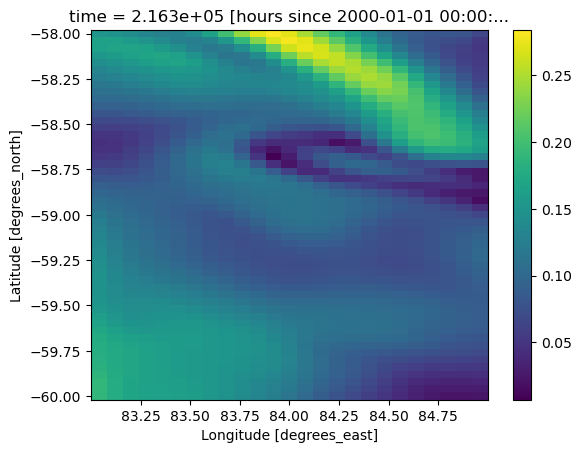

In [22]:

# Plot the currents (optional visualization)
region.plot()